In [1]:
# Import necessary libraries
from roboflow import Roboflow
import zipfile
import os
import json
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from dotenv import load_dotenv

In [2]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
# Initialize COCO object
coco = COCO('Self-Driving-Car-3\export\_annotations.coco.json')

invalid escape sequence '\e'
invalid escape sequence '\e'
invalid escape sequence '\e'


loading annotations into memory...
Done (t=1.18s)
creating index...
index created!


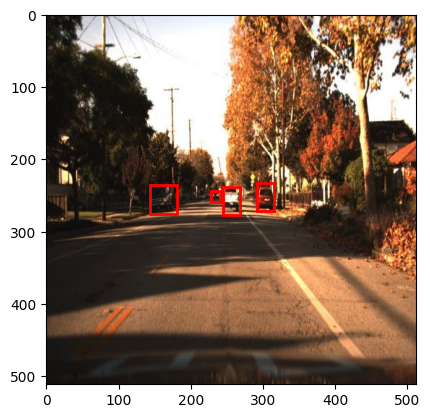

In [4]:
# Get image and annotation IDs
img_id = coco.getImgIds()[30]
img_info = coco.loadImgs(img_id)[0]
img_path = 'Self-Driving-Car-3/export/' + img_info['file_name']

# Load the image
img = Image.open(img_path)

# Load annotations for the image
ann_ids = coco.getAnnIds(imgIds=img_info['id'])
anns = coco.loadAnns(ann_ids)

# Display the image and annotations
plt.imshow(img)
ax = plt.gca()

for ann in anns:
    bbox = ann['bbox']
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)

plt.axis('on')
plt.show()


In [5]:
print(anns)

[{'id': 174, 'image_id': 30, 'category_id': 2, 'bbox': [144, 236, 37, 39.5], 'area': 1461.5, 'segmentation': [], 'iscrowd': 0}, {'id': 175, 'image_id': 30, 'category_id': 2, 'bbox': [228, 244, 14, 14.5], 'area': 203, 'segmentation': [], 'iscrowd': 0}, {'id': 176, 'image_id': 30, 'category_id': 2, 'bbox': [244, 238, 24, 38.5], 'area': 924, 'segmentation': [], 'iscrowd': 0}, {'id': 177, 'image_id': 30, 'category_id': 2, 'bbox': [292, 232, 23.5, 39.5], 'area': 928.25, 'segmentation': [], 'iscrowd': 0}]


In [6]:
# List all categories in the dataset
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]
print("Categories:", category_names)

Categories: ['obstacles', 'biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']


In [7]:
# Count annotations for each category
for category in categories:
    cat_id = category['id']
    annotation_ids = coco.getAnnIds(catIds=cat_id)
    print(f"Category: {category['name']}, Number of annotations: {len(annotation_ids)}")


Category: obstacles, Number of annotations: 0
Category: biker, Number of annotations: 3704
Category: car, Number of annotations: 127873
Category: pedestrian, Number of annotations: 21491
Category: trafficLight, Number of annotations: 5101
Category: trafficLight-Green, Number of annotations: 10838
Category: trafficLight-GreenLeft, Number of annotations: 614
Category: trafficLight-Red, Number of annotations: 13673
Category: trafficLight-RedLeft, Number of annotations: 3482
Category: trafficLight-Yellow, Number of annotations: 541
Category: trafficLight-YellowLeft, Number of annotations: 28
Category: truck, Number of annotations: 7194


In [8]:
# Preprocess images and annotations
data_dir = "Self-Driving-Car-3"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
from torchvision.transforms import functional as F                   

In [10]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import json

class SelfDrivingCarDataset(Dataset):
    def __init__(self, data_dir, annotations_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)
        self.image_info = {img['id']: img for img in self.annotations['images']}
        self.annotation_info = self.annotations['annotations']
        self.image_ids = list(self.image_info.keys())
        
        # Define categories
        self.categories = [
            'obstacles', 'biker', 'car', 'pedestrian', 'trafficLight', 
            'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 
            'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck'
        ]
        # Map category_id to index
        self.category_to_idx = {i+1: idx for idx, i in enumerate(range(len(self.categories)))}

    def resize_image_and_boxes(self, image, boxes, size):
        orig_width, orig_height = image.size
        new_width, new_height = size
        image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

        resized_boxes = []
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            x_min = int(x_min * new_width / orig_width)
            y_min = int(y_min * new_height / orig_height)
            x_max = int(x_max * new_width / orig_width)
            y_max = int(y_max * new_height / orig_height)
            resized_boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])

        return image, resized_boxes

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.image_info[img_id]
        img_path = os.path.join(self.data_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")
        
        boxes = []
        labels = []
        categories = []
        
        for ann in self.annotation_info:
            if ann['image_id'] == img_id:
                x_min, y_min, width, height = ann['bbox']
                x_max = x_min + width
                y_max = y_min + height
                boxes.append([x_min, y_min, x_max, y_max])
                category_id = ann['category_id']
                labels.append(category_id)
                categories.append(self.category_to_idx[category_id])

        if self.transform:
            image, boxes = self.resize_image_and_boxes(image, boxes, (128, 128))
            image = self.transform(image)
        
        return image, boxes, labels, categories



In [11]:
# Define paths
data_dir = "Self-Driving-Car-3/export"
annotations_file = os.path.join(data_dir, "_annotations.coco.json") 

# Load annotations
with open(annotations_file, 'r') as f:
    annotations = json.load(f)

In [12]:
def custom_collate_fn(batch):
    images, boxes, labels, categories = zip(*batch)

    # Clone and detach images to avoid the warning
    images = torch.stack([img.clone().detach() for img in images])

    # Boxes, labels, and categories can be kept as lists of tensors
    boxes = [torch.tensor(b).clone().detach() for b in boxes]
    labels = [torch.tensor(l).clone().detach() for l in labels]
    categories = [torch.tensor(c).clone().detach() for c in categories]

    return images, boxes, labels, categories


In [13]:
def split_dataset(dataset, test_size=0.2, subset_ratio=1.0):
    # Split into train and test indices
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size)
    
    # Apply subset ratio
    train_subset_size = int(len(train_indices) * subset_ratio)
    test_subset_size = int(len(test_indices) * subset_ratio)
    
    train_indices = np.random.choice(train_indices, train_subset_size, replace=False)
    test_indices = np.random.choice(test_indices, test_subset_size, replace=False)
    
    # Create subsets
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)
    
    return train_subset, test_subset

In [14]:
# Create dataset
dataset = SelfDrivingCarDataset(data_dir, annotations_file, transform)

# Split dataset into training and testing subsets with a smaller subset ratio
train_dataset, test_dataset = split_dataset(dataset, test_size=0.2, subset_ratio=0.1) 

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)

In [15]:
# Get a sample from the dataset
image, boxes, labels, categories = train_dataset[0]
print(type(image))  # Check the type of the image

<class 'torch.Tensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


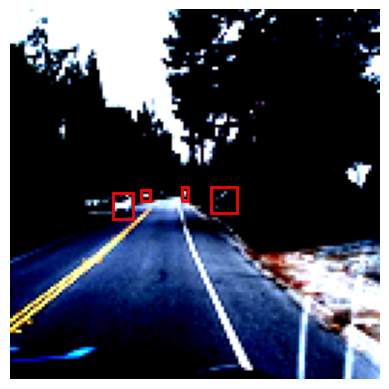

In [16]:
def visualize_data(image, boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for displaying

    for box in boxes:
        x, y, w, h = box
        rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Get a sample from the dataset
image, boxes, labels, categories = train_dataset[2]
visualize_data(image, boxes)

In [17]:
class DrivingEnv:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.data_iter = iter(dataloader)  # Create an iterator over the dataloader
        self.current_state = None

    def reset(self):
        self.data_iter = iter(self.dataloader)  # Reset the iterator
        self.current_state = next(self.data_iter)  # Get the first batch
        return self.current_state

    def step(self, action):
        try:
            self.current_state = next(self.data_iter)  # Get the next batch
            done = False
        except StopIteration:
            done = True  # No more data available

        reward = 0
        if not done:
            # Penalize or reward based on action and situation
            if self._is_danger_ahead(self.current_state):
                if action == "stop":
                    reward += 1  # Reward for stopping in front of danger
                else:
                    reward -= 10  # Penalize heavily for moving towards danger
            else:
                if action == "go":
                    reward += 1  # Reward for moving safely
                else:
                    reward -= 1  # Penalize for stopping unnecessarily

            # Further penalties for proximity to danger
            reward += self._proximity_penalty(self.current_state)

        # End of episode penalty/reward
        if done:
            if self._is_danger_ahead(self.current_state):
                reward -= 100  # Large penalty for ending in a collision
            else:
                reward += 50  # Large reward for completing safely

        return self.current_state, reward, done, {}

    def _is_danger_ahead(self, state):
        image, boxes, labels, categories = state  # Unpack the state to include categories
        for box, label, category in zip(boxes, labels, categories):
            if category in ['car', 'pedestrian', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow']:
                if box[1] < 300:  # Example condition for danger proximity
                    return True
        return False

    def _proximity_penalty(self, state):
        """Calculates a penalty based on how close the agent is to danger."""
        image, boxes, labels, categories = state
        penalty = 0
        for box, label, category in zip(boxes, labels, categories):
            if category in ['car', 'pedestrian']:
                distance = box[1]  # Assuming y-coordinate is forward distance
                if distance < 100:
                    penalty -= 5  # Heavier penalty for closer objects
                elif distance < 200:
                    penalty -= 3
                elif distance < 300:
                    penalty -= 1
        return penalty


In [18]:
# Assuming dataset is already prepared and loaded
env = DrivingEnv(train_dataloader)

# Reset the environment to start
state = env.reset()

In [19]:
# Take an action
next_state, reward, done, _ = env.step("go")

# Print the results
print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)

Next State: (tensor([[[[ 2.2318,  2.2147,  2.2489,  ..., -1.6727, -1.5357, -1.3815],
          [ 2.2489,  2.2489,  2.2489,  ..., -1.5185, -1.4329, -1.3987],
          [ 2.2489,  2.2489,  2.2489,  ..., -1.3473, -1.4672, -1.4672],
          ...,
          [-1.2617, -1.2788, -1.2959,  ...,  0.7933,  0.8961,  0.8961],
          [-1.5014, -1.4843, -1.5014,  ...,  0.7248,  0.8104,  0.9646],
          [-1.5357, -1.5014, -1.4843,  ...,  0.7762,  0.8618,  0.9646]],

         [[ 2.4111,  2.3936,  2.4286,  ..., -1.5805, -1.4405, -1.2829],
          [ 2.4286,  2.4286,  2.4286,  ..., -1.4230, -1.3354, -1.3004],
          [ 2.4286,  2.4286,  2.4286,  ..., -1.2479, -1.3704, -1.3704],
          ...,
          [-1.1429, -1.1604, -1.1779,  ...,  0.9405,  1.0630,  1.0455],
          [-1.3880, -1.3704, -1.3880,  ...,  0.8704,  0.9580,  1.1155],
          [-1.4230, -1.3880, -1.3704,  ...,  0.9230,  1.0105,  1.1155]],

         [[ 2.6226,  2.6051,  2.6400,  ..., -1.3513, -1.2119, -1.0550],
          [ 2.640

In [20]:
# Assuming the first element is the image tensor
image_tensor = state[0]

# Print the shape of the image tensor
print(f"Image tensor shape: {image_tensor.shape}")

Image tensor shape: torch.Size([2, 3, 128, 128])


In [21]:
# Flatten the image tensor to match the expected input of the DQN
flattened_image_tensor = torch.flatten(image_tensor, start_dim=1)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

In [23]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        # Flatten the input tensor (batch_size, flattened_dim)
        x = torch.flatten(x, start_dim=1)
        
        # Debug: Check the shape after flattening
        #print(f"Flattened input shape: {x.shape}")
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
state_dim = 98304  # This gives you the correct flattened dimension
action_dim = 2  # Assuming "go" and "stop"
model = DQN(state_dim, action_dim)

In [25]:
# Pass the flattened image tensor to the model
#output = model(flattened_image_tensor)

# Print the output to see the model's prediction
#print(f"Model output: {output}")

In [26]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration-exploitation trade-off
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 32
memory_size = 5000


In [27]:
# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [28]:
# Replay buffer
memory = deque(maxlen=memory_size)

In [29]:
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

def act(state):
    if np.random.rand() <= epsilon:
        return random.randrange(action_dim)
    state = torch.FloatTensor(state).unsqueeze(0)
    q_values = model(state)
    return np.argmax(q_values.detach().numpy())

def replay():
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward + gamma * np.max(model(next_state).detach().numpy())
        target_f = model(torch.FloatTensor(state).unsqueeze(0)).detach().numpy()
        target_f[0][action] = target
        target_f = torch.FloatTensor(target_f)
        optimizer.zero_grad()
        outputs = model(torch.FloatTensor(state).unsqueeze(0))
        loss = criterion(outputs, target_f)
        loss.backward()
        optimizer.step()

def train_dqn(episodes):
    global epsilon
    for e in range(episodes):
        state = env.reset()
        image, annotations, class_labels, categories = state  # Assuming state is a tuple (image, annotations)
        state = image.flatten()  # Flatten the image
        done = False
        total_reward = 0
        while not done:
            action = act(state)
            next_state, reward, done, _ = env.step("go" if action == 0 else "stop")
            next_image, next_annotations, next_class_labels, next_categories = next_state  # Assuming next_state is a tuple (image, annotations)
            next_state = next_image.flatten()  # Flatten the next image
            remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        replay()
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        print(f"Episode {e+1}/{episodes} - Total Reward: {total_reward}")

In [ ]:
# Train the DQN
train_dqn(episodes=100)

Episode 1/100 - Total Reward: 9
Episode 2/100 - Total Reward: 51
Episode 3/100 - Total Reward: 93
Episode 4/100 - Total Reward: 55
Episode 5/100 - Total Reward: 83
Episode 6/100 - Total Reward: 135
Episode 7/100 - Total Reward: 19
Episode 8/100 - Total Reward: -13
Episode 9/100 - Total Reward: 79
Episode 10/100 - Total Reward: 57
Episode 11/100 - Total Reward: 45
Episode 12/100 - Total Reward: 101
Episode 13/100 - Total Reward: 121
Episode 14/100 - Total Reward: 95


In [ ]:
state = env.reset()
image_tensor = state[0]
annotations_tensor = state[1]
third_element = state[2]

print(f"Image Tensor: {image_tensor.shape}")
print(f"Annotations Tensor: {annotations_tensor}")
print(f"Third Element: {third_element}")

Image Tensor: torch.Size([4, 3, 512, 512])
Annotations Tensor: [tensor([[129.0000, 188.0000, 184.5000, 261.0000],
        [345.0000, 228.0000,  69.0000,  88.0000],
        [418.0000, 175.0000,   8.0000,  24.5000],
        [418.0000, 242.0000,  11.5000,  30.5000],
        [420.0000, 239.0000,   8.5000,  32.5000],
        [431.0000, 236.0000,   8.5000,  43.5000],
        [471.0000, 215.0000,   6.0000,  21.5000],
        [494.0000, 236.0000,  18.0000,  37.5000]]), tensor([[  0.0000, 253.0000,  24.0000,  29.0000],
        [ 70.0000, 250.0000,  21.5000,  38.5000],
        [ 72.0000, 225.0000, 101.0000, 128.0000],
        [194.0000, 239.0000,  21.5000,  26.5000],
        [197.0000, 245.0000,  15.5000,  21.5000],
        [241.0000, 242.0000,  26.0000,  46.0000],
        [271.0000, 239.0000,  43.0000,  54.0000],
        [305.0000, 228.0000, 145.0000,  97.5000],
        [308.0000, 237.0000, 122.0000,  86.0000]]), tensor([[160.0000, 255.0000,  22.0000,  26.5000],
        [162.0000, 255.0000,  18